In [1]:
#Donation data received in csv format. Our goal is to classify individual donors as minor or major
#based on their donation history. Major donors are those who have made a single donation of $1000 or more.
#Once the classifier is trained, it can be used to predict existing minor donors who are likely
#to become major donors.

#We use pandas to manage the data, and a random forest classifier as our model.
import pandas as pd
from sklearn.metrics import roc_auc_score as roc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import itertools

#The model's outcome is evaluated with a confusion matrix.
def confusion_matrix(predicted, truth):
    """ Take Pandas series as input. """
    pred = pd.concat([predicted, truth], axis=1)
    pred.columns = ['predicted','truth']
    tp = len(pred[(pred['truth']==1)&(pred['predicted']==1)])
    tn = len(pred[(pred['truth']==0)&(pred['predicted']==0)])
    fp = len(pred[(pred['truth']==0)&(pred['predicted']==1)])
    fn = len(pred[(pred['truth']==1)&(pred['predicted']==0)])
    cm = np.array([[tn,fp],[fn,tp]])
    classes = ['0','1']
    label = {0:{1:'False Positive',0:'True Negative'},1:{0:'False Negative',1:'True Positive'}}

    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
    plt.title('Confusion matrix',fontsize=12)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '%s \n %d'%(label[i][j],cm[i, j]),
                 horizontalalignment="center",verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=12)
    plt.tight_layout()
    plt.ylabel('True label',fontsize=12)
    plt.xlabel('Predicted label',fontsize=12)
    plt.show()
        
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fpr = fp/(fp+tn) # False alarm
    fnr = fn/(fn+tp) # Miss rate
    f1 = 2*tp/(2*tp+fp+fn)
    
    print('Accuracy            : %3.2f' % accuracy)
    print('Precision           : %3.2f' % precision)
    print('Recall              : %3.2f' % recall)
    print('False positive rate : %3.2f' % fpr)
    print('False negative rate : %3.2f' % fnr)
    print('F1 score            : %3.2f' % f1)

In [2]:
#We import the data which was cleaned and processed in the feature-engineering.ipynb file.
#Each donor has a unique ID "cnBioID" used to track their interactions with the charity.
#interaction_features.csv contains information on how many, and what type, of interations the charity 
#had with each donor for each calendar year. These features were engineered in NewFeatures.ipynb from the raw data.
#constituents_with_target_features.csv contains additional information about the donors, including our target label,
#whether they are a minor or major donor.
int_df = pd.read_csv('./interaction_features.csv', dtype = {'cnBioId': str})
date_cols = ['firstGiftDate', 'emailOptOutDate', 'onlineFirstTransDate', 'onlineLastTransDate', 'onlineLargestTransDate', 'creationDate']
df = pd.read_csv('./constituents_with_target_features.csv', dtype = {'inRe': int, 'inLo': int}, parse_dates=date_cols,low_memory=False, infer_datetime_format=True)


In [3]:
joined_df = pd.merge(df,int_df,how='left', on='cnBioId')
#Date Encoding
for col in date_cols:
    joined_df[col]=joined_df[col].transform(lambda x: (x-pd.datetime(2014,4,1)).days)
#We drop some columns deemed to be the least useful
joined_df_dropped = joined_df.drop(columns=['cnBioId', 'deceasedDate', 'luminateid', 'target_10000', 'amount_last_year', 
                                           'cnBioIdForSpouse', 'previousPostalCodes', 'previousPostalCodes1', 'previousPostalCodes2',
                                           'postalCode']+
                                  ['lifetimeActions', 'lifetimeEventParticipations', 'lifetimeAppeals', 'onlineLifetimeTotalTransAmount', 'onlineLifetimeTotalTransCount'])
# Fix misformatting
joined_df_dropped['deceased'] = joined_df_dropped['deceased'].map({True: 1})

#Separate categorical features from the rest
cat_features = list(joined_df_dropped.columns[joined_df_dropped.dtypes == 'object'])
joined_df_dropped.loc[:,cat_features]=joined_df_dropped.loc[:,cat_features].fillna('unknown')

#Separate out our target label of major donors who have given $1000 or more.
y= joined_df_dropped['target_1000'].values
joined_df_dropped=joined_df_dropped.drop(columns=['target_1000'])

#Normalize categorical labels, and fill in missing values.
for col in joined_df_dropped.columns:
    if col in cat_features:        
        le = LabelEncoder()
        joined_df_dropped[col]= le.fit_transform(joined_df_dropped[col].values)
        #ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        #joined_df_dropped[col]= ohe.fit_transform(joined_df_dropped[col].values.reshape(-1, 1))
    else:
        fillval = joined_df_dropped[col].mean()
        if not np.isnan(fillval):
            joined_df_dropped[col]=joined_df_dropped[col].fillna(fillval)
        else:
            joined_df_dropped[col]=joined_df_dropped[col].fillna(0)
        

X = joined_df_dropped.values
#This is our cleaned training data

clf = RandomForestClassifier(n_estimators=1000, max_depth=12, random_state=42, class_weight='balanced_subsample')
cv_result = cross_val_score(clf, X, y, cv=3, scoring='roc_auc')

In [4]:
#We do stratified cross-validation using a random forest classifier and collect the out-of-fold predictions.
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)
pred_oof = np.zeros(y.shape)
for train_index, test_index in skf.split(X, y):
    clf = RandomForestClassifier(n_estimators=1000, max_depth=12, random_state=42, class_weight='balanced_subsample')
    clf.fit(X[train_index, :], y[train_index])
    pred_oof[test_index] = clf.predict_proba(X[test_index,:])[:,1]

In [5]:
#The AUC of ROC score
roc(y, pred_oof)

0.9397505580294869

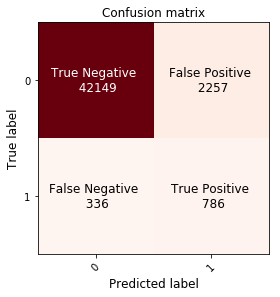

Accuracy            : 0.94
Precision           : 0.26
Recall              : 0.70
False positive rate : 0.05
False negative rate : 0.30
F1 score            : 0.38


In [6]:
#Our main goal is to maximize Recall while maintaining some Precision. We want to find as many major donors
# as possible, since these people are responsible for a disproportionately large amount
# of total donations. False positives are not too bad, since we may want to follow up with these
# donors in any case.
confusion_matrix(pd.Series(pred_oof>0.4), pd.Series(y))